# Styletransfer Experiments

TO Expand the data that can be used for training we had an idea of generating new images ourselves, which might potentially allow for greater control over the input data.

The idea was to first create new groundtruth data using random lines and bezier curves, best as sdf's such that there can be some control over the vicinity of the roads.
Then once the groundtruth map is generated a styletransfer network should be employed on a noisy version of the groundtruth image to "paint in" some realistic looking details similar to the provided training images as a style reference.

This approach failed. First, the generation of "believable" roads is very tricky, as randomness does not really cut it and generating a city-road generator is out of the scope of this project.
Second, the stlye transfer, even on handcrafted images does not work well at all and takes half a minute to just generate a single new image. The resulting images also lack realism and distort the roads slightly as well as may add new roads, or something that may be mistaken as a road. Therefore this approach was abandoned.

Below is the standard example code from the torch website:
https://pytorch.org/tutorials/advanced/neural_style_tutorial.html
adjusted to run on images of this project

In [2]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torchvision.transforms as transforms
import torchvision.models as models

import copy
import PIL


training_base_dir = os.path.join("training","images")
training_filenames = [os.path.join(training_base_dir, name) for name in os.listdir(training_base_dir)]

imsize = 400

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
loader = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])
unloader = transforms.ToPILImage()

def image_loader(image_name):
    image = PIL.Image.open(image_name).convert('RGB')
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

def tensor_to_image(tensor):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    return image

def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c* d)
    G = torch.mm(features, features.t())
    return G.div(a*b*c*d)

class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input


class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [5]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [21]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_14']
style_layers_default = ['conv_1', 'conv_2', 'conv_4', 'conv_6', 'conv_10', 'conv_13', 'conv_16' ] # up to conv16


cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = mean.clone().detach().view(-1, 1, 1)
        self.std = std.clone().detach().view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std


def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)
        
        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses


def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

def plot_results(content_img, output_img, style_img):
    plt.ion()
    figure, axes = plt.subplots(1,3)
    figure.set_size_inches(10,5)
    axes[0].imshow(tensor_to_image(content_img))
    axes[0].title.set_text("content")
    axes[1].imshow(tensor_to_image(output_img))
    axes[1].title.set_text("output")
    axes[2].imshow(tensor_to_image(style_img))
    axes[2].title.set_text("style")

def save_result(image_name, image):
    output_name = os.path.join("transfer_generated",image_name+"_seg.png")
    img = transforms.ToPILImage()(image.detach()[0])
    img.save(output_name)


def transfer_style(gt_image_name="generated0_seg.png", training_style_index=15, add_noise=False):
    example_style_image = training_filenames[training_style_index]

    content_img = image_loader(os.path.join("transfer_generated", gt_image_name))
    if(add_noise):
        content_img = content_img + torch.randn_like(content_img)*0.6 # add some noise to help the styletransfer "imagine" structures
        
    style_img = image_loader(example_style_image)
    
    output_img = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                                content_img, style_img, content_img.clone(), num_steps=300)

    return (content_img, output_img, style_img)

### Some examples:

1. No added Noise

In [ ]:
content_img, output_img, style_img = transfer_style("generated0_seg.png", 15, add_noise=False)

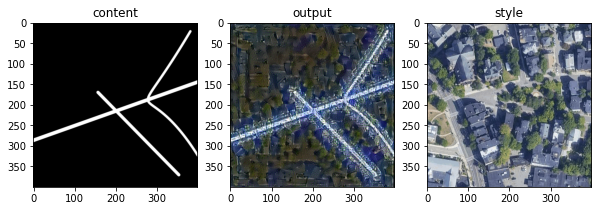

In [23]:
plot_results(content_img, output_img, style_img)

2. added Noise

In [ ]:
content_img, output_img, style_img = transfer_style("generated0_seg.png", 15, add_noise=True)

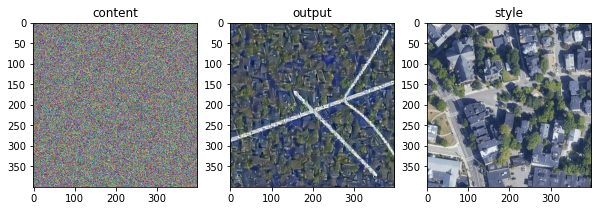

In [26]:
plot_results(content_img, output_img, style_img)

3. Handcrafted to hope for better features (would be needed to create in the generator, but at this point it was just a proof of concept)

In [ ]:
content_img, output_img, style_img = transfer_style("handcrafted0_seg.png", 15, add_noise=True)

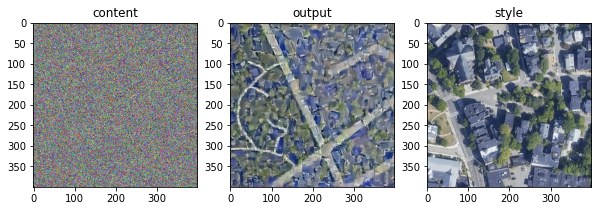

In [28]:
plot_results(content_img, output_img, style_img)

4. Really trying to handpaint even structures (which would be very hard to procedurally generate) does not yield usable results. We do not pursue this approach further

In [ ]:
content_img, output_img, style_img = transfer_style("handcrafted2_seg.png", 15, add_noise=True)

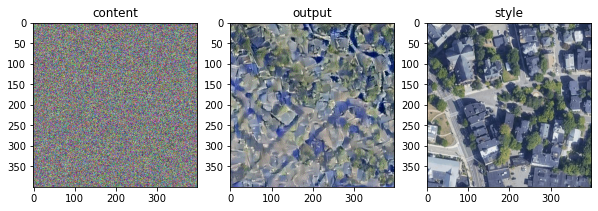

In [32]:
plot_results(content_img, output_img, style_img)